## Similar paper: https://www.ncbi.nlm.nih.gov/pmc/articles/PMC4540970/

In [1]:
import pandas as pd
import numpy as np
import os
# import json
# import copy
from matplotlib import pyplot as plt
# from matplotlib_venn import venn2
# import path

# from pathwayenrichment.representation import ClusterPermutator
# from pathwayenrichment.databaseparser import KEGGPathwayParser 

from dokdonia import differentialexpression as DE
from dokdonia import visualization as VI
from dokdonia import clusteranalysis as CA
from dokdonia.pathway import KEGGPathwayParser
from dokdonia.utils import saveToPickleFile, readFromPickleFile, GenomeGBK

# plt.style.use('plt_styles.mplstyle')
%matplotlib inline

## Get KEGG pathways for _Dokdonia_

In [3]:
from dokdonia.pathway import KEGGPathwayParser

KEGGparser = KEGGPathwayParser.fromKEGGidentifier('dok', only_curated_pathways=True)
gene_pathways, gene_systems = KEGGparser.getGenePathways()
system_pathways = KEGGparser.getSystemPathways()
gene_info = KEGGparser.getGeneInfoFromKEGGorthology()
gene_list = list(gene_pathways.keys())
print(f'There are a total of {len(gene_list)} genes')

There are a total of 786 genes


# Load count data

In [4]:
# Loading counts and removing genes with low read counts across samples
min_count = 10

counts = pd.read_csv('data/DokdoniaCounts.csv', index_col=0)
counts = counts[counts.filter(regex='^[^T]+$').columns]
conditions = [name.split('.sam')[0] for name in counts.columns]
counts.columns = conditions
counts = counts[(counts > min_count).all(1)]
counts.reset_index(level=0, inplace=True)
counts.head()

,index,D_10_R1,D_10_R2,D_10_R3,D_18_R1,D_18_R2,D_18_R3,D_18_R4,D_25_R1,D_25_R2,...,L_18_R2,L_18_R3,L_18_R4,L_25_R1,L_25_R2,L_25_R3,L_34_R1,L_34_R2,L_34_R3,L_34_R4
0,MED134_07389,12973,11426,13251,30624,30618,41014,22449,53840,32369,...,16255,23945,20102,39444,41721,37020,39662,30983,27280,57834
1,MED134_07384,1557,1555,1552,4160,4385,5588,2940,7550,4509,...,2564,3003,2894,5419,5536,5318,5396,4751,4285,7818
2,MED134_07379,3400,3319,3273,7218,7903,9539,5040,13268,7572,...,4575,5361,4923,9089,9016,8529,10179,7617,7207,13827
3,MED134_07374,1987,2124,1404,3509,3772,4337,2602,4607,3316,...,1798,2558,2637,3586,3594,3488,4158,3096,2623,5323
4,MED134_07369,2087,2010,2111,3774,3809,4486,2901,4668,3456,...,2545,3456,3008,3705,4158,3760,5518,3563,2713,5150


# Find DE genes between Light and Dark

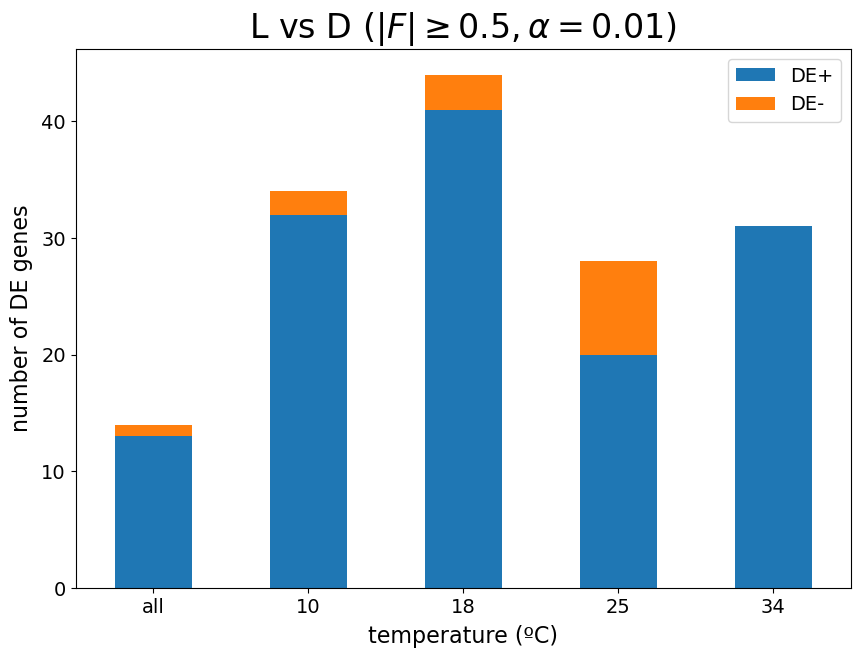

In [5]:
p_value_cutoff = 1e-2
fold_cutoff = k = 0.5

# DE light vs dark across temperatures
L_D_res, L_D_stats = {}, {}
L_D_res['all'], L_D_stats['all'] = DE.runDEtest(counts, test='Wald', alpha=p_value_cutoff,
                                                formula='~ lighting', log2fold_cutoff=k)
# L vs D for each temperature
for T in ['10', '18', '25', '34']:
    counts_T = counts[counts.filter(regex=f'{T}|index').columns]    
    L_D_res[T], L_D_stats[T] = DE.runDEtest(counts_T, test='Wald', alpha=p_value_cutoff,
                                            formula='~ lighting', log2fold_cutoff=k)
# Plot stats
ax = pd.DataFrame(L_D_stats).transpose().plot.bar(
    stacked=True, title=f'L vs D ($|F|\\geq 0.5,\\alpha={p_value_cutoff}$)',
    figsize=(10, 7), ylabel='number of DE genes', xlabel='temperature (ºC)',
    rot=0)

In [6]:
L_D_stats['18']

{'DE+': 41, 'DE-': 3}

We find DE genes, with a absolute fold cutoff value $|K|\geq0.5$ and significance level $\alpha=0.01$ across all temperatures. In all cases, there are more genes with greater expression under light than those with greater expression in the dark.

Let's look at the lists of DE genes across  temperatures:

In [13]:
# L > D, T = 18 Proteins [Sale alguno en cluster?]
gbk = GenomeGBK('data/DokdoniaMED134.gbk')
DELD = {}
for T, res in L_D_res.items():
    DELD[T] = {
        'L>D': {
            gene_id: gbk.getGeneInfo(gene_id)['product'][0] + " - " + gene_pathways[gene_id][0] if gene_id in gene_pathways else "unspecified"
            for gene_id in res[res.log2FoldChange >= k].index
        },
        'D>L': {
            gene_id: gbk.getGeneInfo(gene_id)['product'][0] + " - " + gene_pathways[gene_id][0] if gene_id in gene_pathways else "unspecified"
            for gene_id in res[res.log2FoldChange <= -k].index
        }
    }
DELD['18']

{'L>D': {'MED134_07319': 'unspecified',
  'MED134_07209': 'unspecified',
  'MED134_07119': 'unspecified',
  'MED134_07089': 'unspecified',
  'MED134_06804': 'unspecified',
  'MED134_06194': 'unspecified',
  'MED134_06129': 'unspecified',
  'MED134_05894': 'arginase family protein - 00330 Arginine and proline metabolism [PATH:dok00330]',
  'MED134_05889': 'Orn/DAP/Arg decarboxylase - 00330 Arginine and proline metabolism [PATH:dok00330]',
  'MED134_05499': 'unspecified',
  'MED134_05339': 'unspecified',
  'MED134_05334': 'GTP cyclohydrolase I - 00790 Folate biosynthesis [PATH:dok00790]',
  'MED134_04999': 'unspecified',
  'MED134_04254': 'unspecified',
  'MED134_04249': 'unspecified',
  'MED134_04009': 'unspecified',
  'MED134_03969': 'unspecified',
  'MED134_03869': '50S ribosomal protein L31 - 03010 Ribosome [PATH:dok03010]',
  'MED134_03409': 'unspecified',
  'MED134_03404': 'unspecified',
  'MED134_15862': 'unspecified',
  'MED134_02025': 'unspecified',
  'MED134_01275': 'unspecifie

# Effect of temperature on L-D DE genes
How do DE genes across light and dark behave across temperatures?

In [8]:
# Get light-dark DE genes at any temperature
k = 0.5
DE_all_T  = np.unique([g for g in L_D_res['all'][abs(L_D_res['all'].log2FoldChange) >= k].index]).tolist()
DE_plus = np.unique([g for L_D_res in L_D_res.values() for g in L_D_res[L_D_res.log2FoldChange >= k].index]).tolist()
DE_minus = np.unique([g for L_D_res in L_D_res.values() for g in L_D_res[L_D_res.log2FoldChange <= -k].index]).tolist()
DE_total = DE_plus + DE_minus
print(f'There are a total of {len(DE_total)} DE genes between Light and Dark')
print(f'There a total of {len(DE_all_T)} Light/Dark DE genes across the entire T range')

There are a total of 74 DE genes between Light and Dark
There a total of 14 Light/Dark DE genes across the entire T range


In [2]:
# Gettranscript/cell dataset
TC = pd.read_csv('data/Dokdonia_transcripts_cell.csv', index_col=0)
TC = TC[TC.filter(regex='^[^T]+$').columns] # remove technical replicates
TC = TC.dropna(axis=1) # Remove L_18_R4 and D_18_R4 which did no have internal standards
TC.iloc[:,1:] = 1e4 * TC.iloc[:,1:] # scale data to avoid numerical issues
TC = TC.set_index('index')
TC.index.name = 'ID'

## DE on multiple comparisons across temperatures
See https://hbctraining.github.io/DGE_workshop/lessons/08_DGE_LRT.html
Fold changes here aren't meaningful.

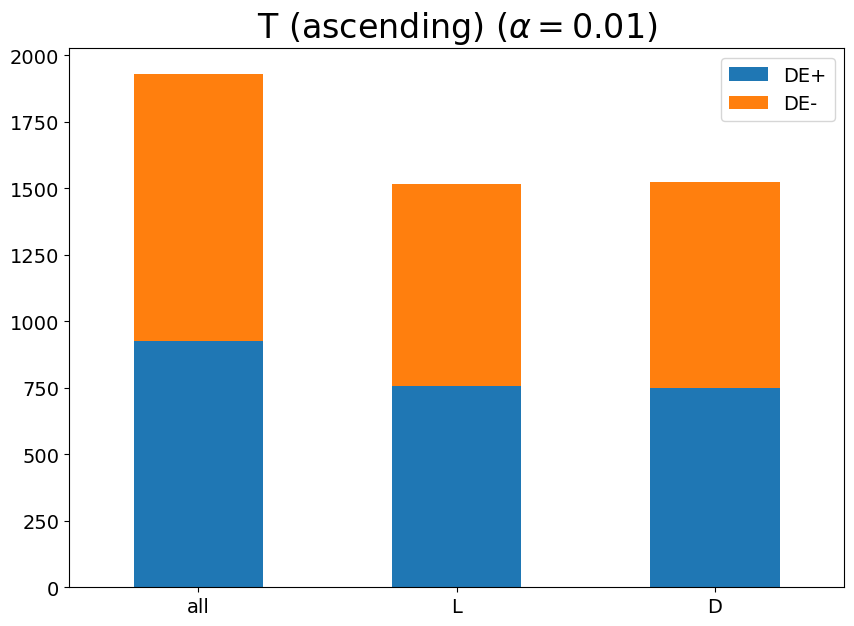

In [9]:
# Do not discriminate between Light and Dark conditions
T_res, T_stats = {}, {}
T_res['all'], T_stats['all'] = DE.runDEtest(counts, test='LRT', alpha=p_value_cutoff,
                                            formula='~ temperature', reduced_formula='~ 1')

# Discriminate between Light and Dark conditions
for L in ['L', 'D']:
    counts_L = counts[counts.filter(regex=f'{L}|index').columns]    
    T_res[L], T_stats[L] = DE.runDEtest(counts_L, test='LRT', alpha=p_value_cutoff,
                                        formula='~ temperature', reduced_formula='~ 1')

saveToPickleFile(T_res, 'results/DE_result.pkl')

# Plot stats
ax = pd.DataFrame(T_stats).transpose().plot.bar(
    stacked=True, title=f'T (ascending) ($\\alpha={p_value_cutoff}$)', figsize=(10, 7), rot=0)

In [ ]:
# Plot L-D Venn diagram
from matplotlib_venn import venn2

plt.figure(figsize=(8, 8))
set1 = set(T_res['L'].index)
set2 = set(T_res['D'].index)
Light_specific_DE_genes = set1 - set2
Dark_specific_DE_genes = set2 - set1
venn2([set1, set2], ('L', 'D'),
      set_colors=('purple', 'skyblue'), alpha = 0.7)
plt.title('DE genes across T (L vs D)')
plt.show()

# Effect of temperature on gene expression: Pathway enrichment analysis

Next, we analyze the effect that temperature may have on gene expression. To this end, we first cluster genes according to their across-temperature expression pattern, and then perform a permutation-based pathway enrichment analysis to evaluate which pathways are most affected by temperature changes.

To separate the effect of light and dark from that of temperature, we leave out of the analysis the set of genes that were DE between light and dark.

In [10]:
# Remove light-dark DE genes from dataset
TCnoDE = TC.loc[~TC.index.isin(DE_all_T)]

## Cluster by gene expression pattern


/===========================================================================\
|                                   Clust                                   |
|    (Optimised consensus clustering of multiple heterogenous datasets)     |
|           Python package version 1.18.0 (2022) Basel Abu-Jamous           |
+---------------------------------------------------------------------------+
| Analysis started at: Wednesday 18 January 2023 (17:22:05)                 |
| 1. Reading dataset(s)                                                     |
| 2. Data pre-processing                                                    |
|  - Flat expression profiles filtered out (default in v1.7.0+).            |
|    To switch it off, use the --no-fil-flat option (not recommended).      |
|    Check https://github.com/BaselAbujamous/clust for details.             |
| 3. Seed clusters production (the Bi-CoPaM method)                         |
| 10%                                                          

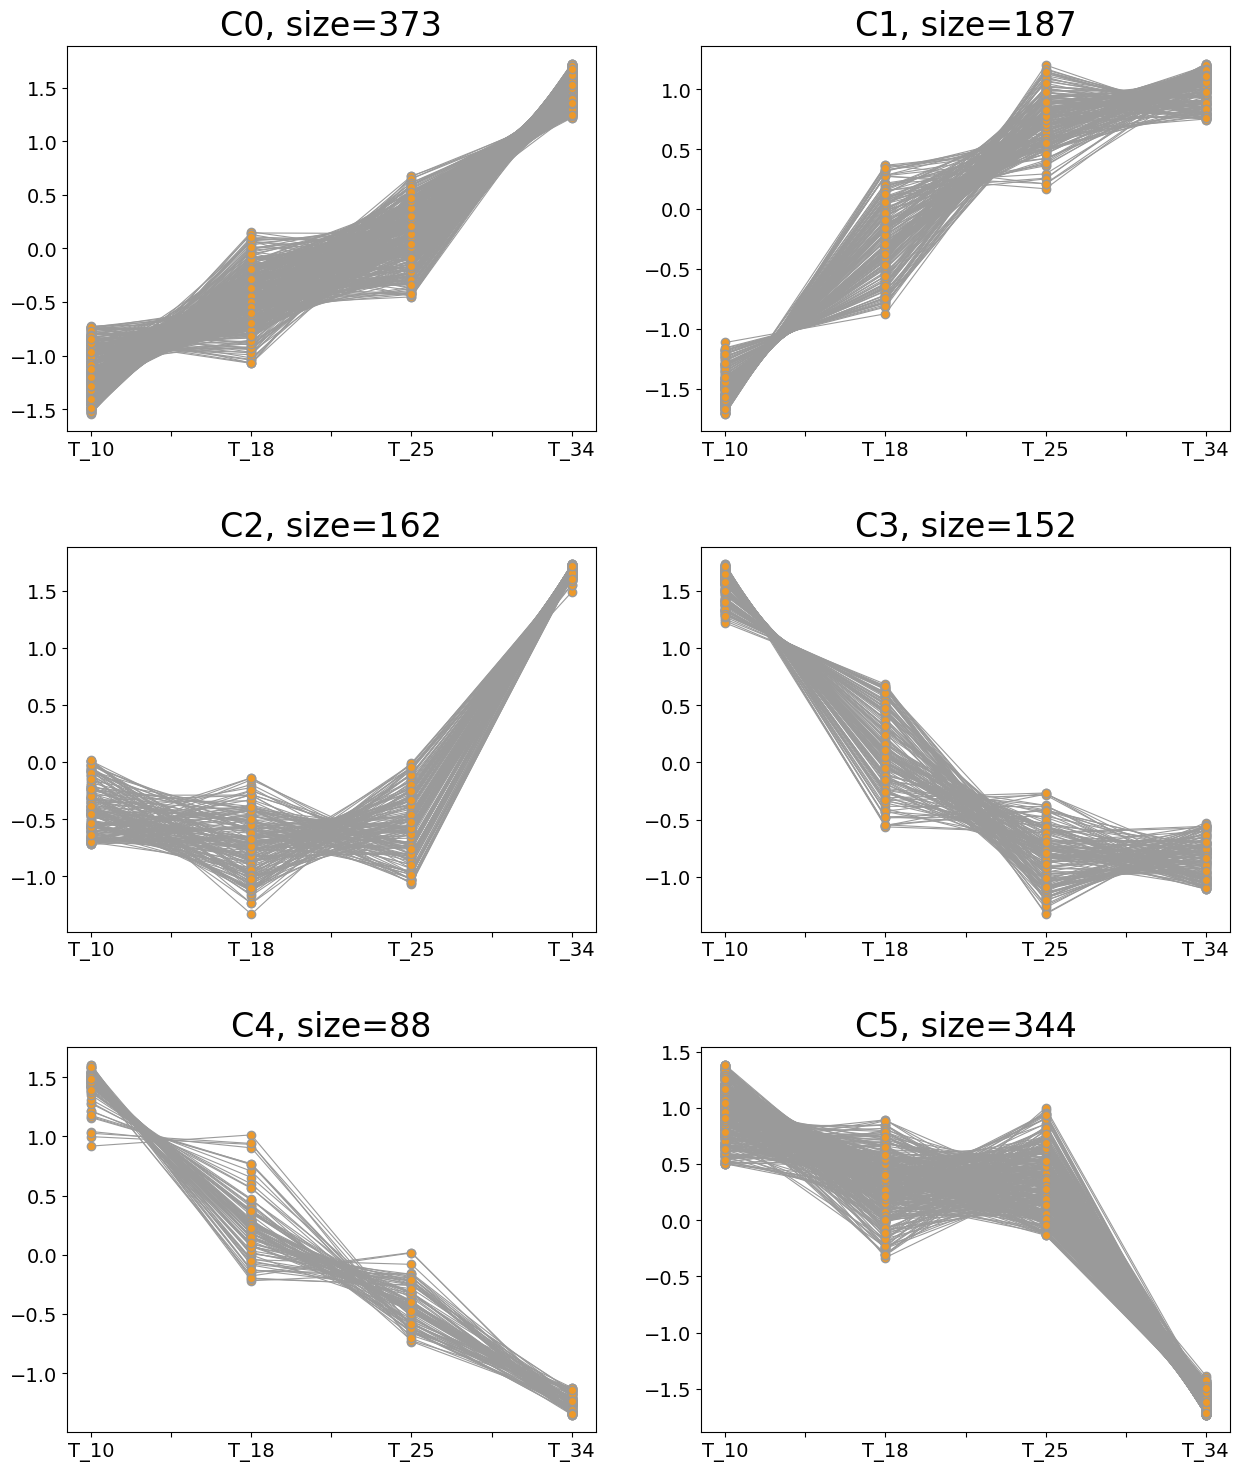

In [3]:
clust_tightness = 5
res_id = 'CLUSTER_ALL_GENES_TRANSCRIPT_CELL'
workdir = os.path.join(os.getcwd(),'results')

clusters = CA.getGeneClusters(TC, path_to_wd=workdir, 
                              out_dir=os.path.join(workdir, res_id),
                              cluster_tightness=clust_tightness,
                              normalization_file='clust_normalization.txt',
                              replicates_file='clust_replicates_merged_L_D.txt')

# Plot clusters
plot_cluster_data = pd.read_csv(os.path.join(
    os.getcwd(),f'results/{res_id}/Processed_Data/clust_input.tsv_processed.tsv'),
    sep='\t', index_col='Genes')
#plot_cluster_data.insert(4, '', [np.nan for n in range(plot_cluster_data.shape[0])])  # Add fake column to separate datasets

VI.plotClusters(plot_cluster_data, clusters)

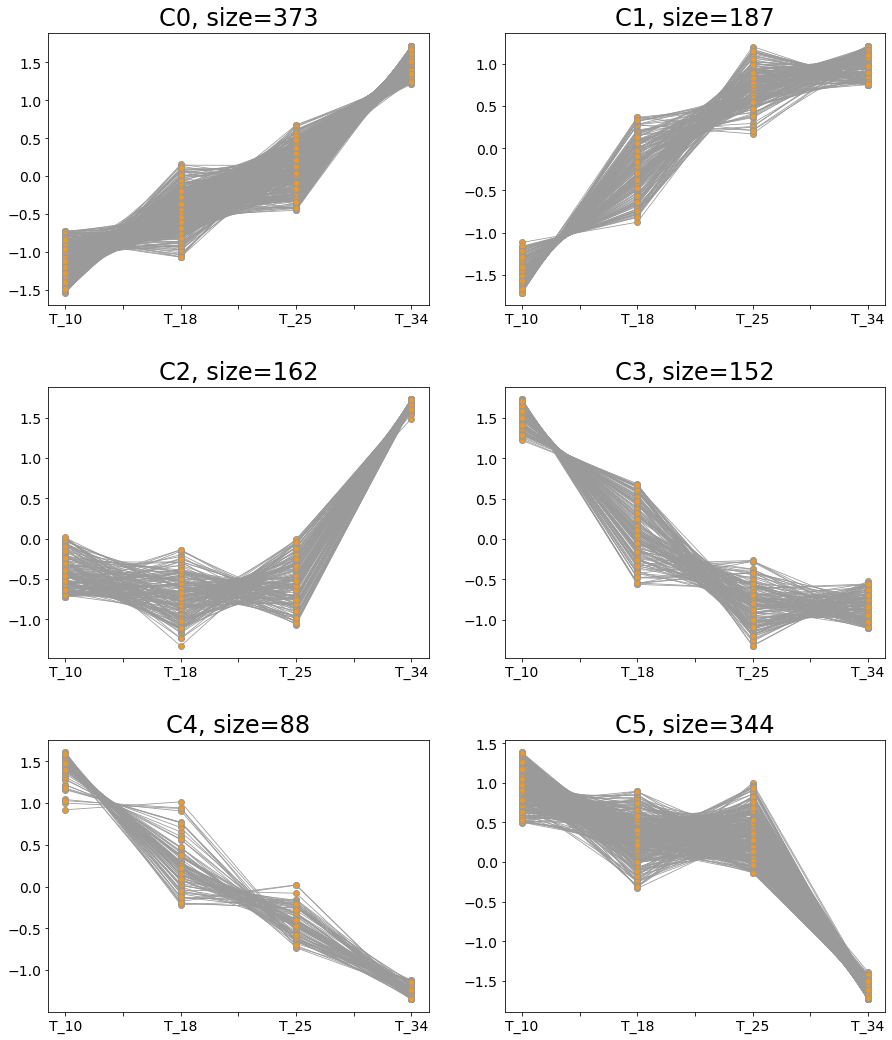

In [7]:
clust_tightness = 5
res_id = 'CLUSTER_ALL_GENES_TRANSCRIPT_CELL'
workdir = os.path.join(os.getcwd(),'results')

clusters = CA.getGeneClusters(TC, path_to_wd=workdir, 
                              out_dir=os.path.join(workdir, res_id),
                              cluster_tightness=clust_tightness,
                              normalization_file='clust_normalization.txt',
                              replicates_file='clust_replicates_merged_L_D.txt')

# Plot clusters
plot_cluster_data = pd.read_csv(os.path.join(
    os.getcwd(),f'results/{res_id}/Processed_Data/clust_input.tsv_processed.tsv'),
    sep='\t', index_col='Genes')
#plot_cluster_data.insert(4, '', [np.nan for n in range(plot_cluster_data.shape[0])])  # Add fake column to separate datasets

VI.plotClusters(plot_cluster_data, clusters)

In [81]:
TC.index[0]
[C for (C, V) in clusters.items() if TC.index[0] in V]

['C1']

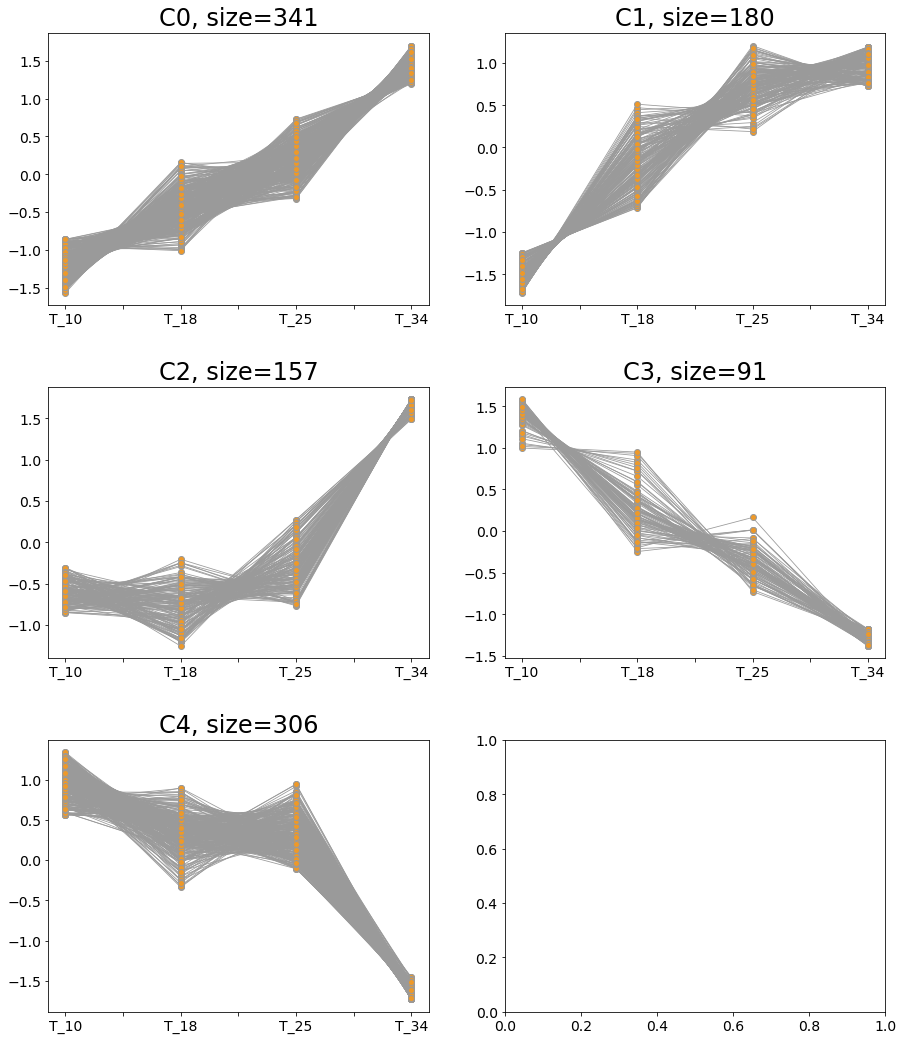

In [27]:
clust_tightness = 5
res_id = 'CLUSTER_NONDE_GENES_TRANSCRIPT_CELL'
workdir = os.path.join(os.getcwd(),'results')

clusters = CA.getGeneClusters(TCnoDE, path_to_wd=workdir, 
                              out_dir=os.path.join(workdir, res_id),
                              cluster_tightness=clust_tightness,
                              normalization_file='clust_normalization.txt',
                              replicates_file='clust_replicates_merged_L_D.txt')

# Plot clusters
plot_cluster_data = pd.read_csv(os.path.join(
    os.getcwd(),f'results/{res_id}/Processed_Data/clust_input.tsv_processed.tsv'),
    sep='\t', index_col='Genes')

VI.plotClusters(plot_cluster_data, clusters)

## Rank genes within clusters

Rank genes within clusters by ther silhouette

In [4]:
res_id = 'CLUSTER_ALL_GENES_TRANSCRIPT_CELL'
cluster_data = pd.read_csv(os.path.join(
    os.getcwd(),f'results/{res_id}/Processed_Data/clust_input.tsv_processed.tsv'),
    sep='\t', index_col='Genes')
ranked_clusters = CA.rankGenesWithinClusters(clusters, cluster_data)

# Questions:

1. Transcript/cell, TPM?

2. Merging Light / Dark conditions into one, removing L-D differentially expressed genes from merged dataset

# Gene set enrichment with R

KEGG subsystems

In [13]:
# Using R's library ClusterProfiler, results: CLUSTER_NONDE_GENES_TRANSCRIPT_CELL/Clusters_Objects.tsv
import pandas as pd

df = pd.read_csv("/home/robaina/Documents/Aquifex/Dokdonia/enrichment_results/results_non_DE_genes.csv")
df.Cluster = df.Cluster.apply(lambda c: "C" + str(int(c[1]) - 1))
df = df.sort_values(["Cluster", "p.adjust"])
df["p.adjust"] = df["p.adjust"]
df[(df.Cluster == "C4") & (df["p.adjust"] <= 0.1)]

,Cluster,ID,Description,GeneRatio,BgRatio,pvalue,p.adjust,qvalue,geneID,Count
5,C4,dok03010,Ribosome,32/102,34/256,1.424779e-12,5.271684e-11,5.271684e-11,MED134_00530/MED134_00535/MED134_00540/MED134_...,32


In [9]:
# All genes transcript/cell
df = pd.read_csv("/home/robaina/Documents/Aquifex/Dokdonia/enrichment_results/results_all_genes.csv")
df.Cluster = df.Cluster.apply(lambda c: "C" + str(int(c[1]) - 1))
df

,Cluster,ID,Description,GeneRatio,BgRatio,pvalue,p.adjust,qvalue,geneID,Count
0,C3,dok00220,Arginine biosynthesis,7/37,8/320,1.182419e-06,4.611436e-05,4.231817e-05,MED134_03489/MED134_11916/MED134_11926/MED134_...,7
1,C3,dok01230,Biosynthesis of amino acids,10/37,28/320,3.737436e-04,7.288000e-03,6.688043e-03,MED134_03489/MED134_09211/MED134_09321/MED134_...,10
2,C3,dok00250,"Alanine, aspartate and glutamate metabolism",5/37,11/320,4.371562e-03,4.262273e-02,3.911398e-02,MED134_01325/MED134_03489/MED134_11946/MED134_...,5
3,C3,dok01210,2-Oxocarboxylic acid metabolism,5/37,11/320,4.371562e-03,4.262273e-02,3.911398e-02,MED134_11916/MED134_11926/MED134_11936/MED134_...,5
4,C5,dok03010,Ribosome,35/113,38/320,9.420929e-15,4.522046e-13,4.522046e-13,MED134_00530/MED134_00535/MED134_00540/MED134_...,35


In [10]:
# All genes TPM (these are generated withou merging Light and Dark conditions)
df = pd.read_csv("/home/robaina/Documents/Aquifex/Dokdonia/enrichment_results/results_all_genes_TPM.csv")
df.Cluster = df.Cluster.apply(lambda c: "C" + str(int(c[1]) - 1))
df

,Cluster,ID,Description,GeneRatio,BgRatio,pvalue,p.adjust,qvalue,geneID,Count
0,C2,dok00071,Fatty acid degradation,3/14,5/251,1.306291e-03,2.399240e-02,1.993829e-02,MED134_06229/MED134_06234/MED134_07646,3
1,C2,dok00362,Benzoate degradation,3/14,6/251,2.525516e-03,2.399240e-02,1.993829e-02,MED134_06229/MED134_06234/MED134_07646,3
2,C2,dok01212,Fatty acid metabolism,3/14,8/251,6.607417e-03,4.184697e-02,3.477588e-02,MED134_04814/MED134_06229/MED134_06234,3
3,C3,dok00360,Phenylalanine metabolism,5/26,9/251,7.731154e-04,2.242035e-02,2.034514e-02,MED134_11671/MED134_11676/MED134_11681/MED134_...,5
4,C4,dok03010,Ribosome,10/100,11/251,5.513947e-04,2.370997e-02,2.370997e-02,MED134_00530/MED134_00640/MED134_02245/MED134_...,10
5,C5,dok01230,Biosynthesis of amino acids,16/27,33/251,9.473729e-10,2.747381e-08,2.094193e-08,MED134_00395/MED134_01810/MED134_03484/MED134_...,16
6,C5,dok00220,Arginine biosynthesis,9/27,10/251,4.639715e-09,6.727587e-08,5.128106e-08,MED134_03484/MED134_03489/MED134_11911/MED134_...,9
7,C5,dok01210,2-Oxocarboxylic acid metabolism,5/27,8/251,4.491773e-04,4.342047e-03,3.309727e-03,MED134_11916/MED134_11926/MED134_11936/MED134_...,5
8,C5,dok01110,Biosynthesis of secondary metabolites,16/27,74/251,6.276321e-04,4.550333e-03,3.468493e-03,MED134_00395/MED134_01810/MED134_02845/MED134_...,16
9,C5,dok00250,"Alanine, aspartate and glutamate metabolism",6/27,14/251,1.470350e-03,8.528030e-03,6.500495e-03,MED134_03484/MED134_03489/MED134_11911/MED134_...,6


# GENUINE question:

Do we need correction for multiple testing in the case of the permutation analysis?

"Also, using permution as here there is only one test, as opposed to running multiple tests one for each pathway and cluster. Hence multiple test correction would not be necessary. Double-check."

## Pathway enrichment analysis

This is equivalent to hypergeometric test, well not quite, I'm doing it simultaneosly for all clusters

In [8]:
# Parse KEGG Dokdonia's orthology
KEGGparser = KEGGPathwayParser.fromKEGGidentifier('dok', only_curated_pathways=True)
gene_pathways, gene_systems = KEGGparser.getGenePathways()
system_pathways = KEGGparser.getSystemPathways()
gene_info = KEGGparser.getGeneInfoFromKEGGorthology()

# Run analysis
permutator = ClusterPermutator(clusters, gene_pathways, system_pathways)

In [10]:
pathway_res = permutator.sampleClusterPermutationSpace(sample_size=200000, n_processes=8)
saveToPickleFile(pathway_res, 'results/enrichment_result_all_genes.pkl')

Finished permutation sampling


In [14]:
pathway_res['pathway']['C2']

{'00500 Starch and sucrose metabolism [PATH:dok00500]': (0.17647058823529413,
  0.02775),
 '00190 Oxidative phosphorylation [PATH:dok00190]': (0.13043478260869565,
  0.02848),
 '00620 Pyruvate metabolism [PATH:dok00620]': (0.15384615384615385, 0.05048),
 '00020 Citrate cycle (TCA cycle) [PATH:dok00020]': (0.13636363636363635,
  0.06521),
 '00290 Valine, leucine and isoleucine biosynthesis [PATH:dok00290]': (0.08333333333333333,
  0.124525),
 '00760 Nicotinate and nicotinamide metabolism [PATH:dok00760]': (0.18181818181818182,
  0.1631),
 '02030 Bacterial chemotaxis [PATH:dok02030]': (0.25, 0.23273),
 '02040 Flagellar assembly [PATH:dok02040]': (0.16666666666666666, 0.23273),
 '00511 Other glycan degradation [PATH:dok00511]': (0.5, 0.233105),
 '00630 Glyoxylate and dicarboxylate metabolism [PATH:dok00630]': (0.13636363636363635,
  0.246635),
 '00230 Purine metabolism [PATH:dok00230]': (0.08108108108108109, 0.317575),
 '00350 Tyrosine metabolism [PATH:dok00350]': (0.125, 0.327055),
 '003

## Visualization

In [11]:
pathway_res = readFromPickleFile('results/enrichment_result_all_genes.pkl')
cluster_colors =     {
        'C0': '#3d03fc', 'C1': '#036bfc', 'C2': '#03adfc',
        'C3': '#fc4e03', 'C4': '#fc0303', 'C5': '#fc7703', 
        'C6': '#03fc7b', 'No cluster': 'white'
    }

VI.plotSystemsAndSubsystemsStacked(pathway_res, cluster_colors, 'imgs/all_genes_Stacked')

# Trying out soft clustering in HDBSCAN

In [11]:
TC

,D_10_R1,D_10_R2,D_10_R3,D_18_R1,D_18_R2,D_18_R3,D_25_R2,D_25_R3,D_34_R1,D_34_R2,...,L_18_R1,L_18_R2,L_18_R3,L_25_R1,L_25_R2,L_25_R3,L_34_R1,L_34_R2,L_34_R3,L_34_R4
ID,,,,,,,,,,,,,,,,,,,,,
MED134_07389,3272.742595,4023.255679,3193.191427,15046.001051,25885.970883,18162.634520,12525.337743,13779.248042,17241.568322,14585.675293,...,10636.784088,10242.042265,6006.706745,11627.525559,10910.352316,14970.913156,8945.846865,9695.256532,12718.703565,14741.535906
MED134_07384,392.789657,547.537422,373.996913,2043.866391,3707.295784,2474.589206,1744.778890,1898.573010,2530.246196,2081.393024,...,1443.568271,1615.539610,753.315530,1597.443490,1447.705242,2150.602814,1217.079060,1486.691533,1997.787565,1992.760793
MED134_07379,857.729502,1168.666690,788.719005,3546.304715,6681.586906,4224.249541,2930.021236,3699.854578,4502.661370,3607.912641,...,2381.739097,2882.641856,1344.830021,2679.306861,2357.751168,3449.133396,2295.894691,2383.525449,3360.106180,3524.418456
MED134_07374,501.267212,747.890343,338.332259,1724.020954,3189.035279,1920.596526,1283.141894,1520.526262,1628.184006,1433.720402,...,1195.986244,1132.894001,641.685356,1057.101376,939.857775,1410.549570,937.845577,968.805933,1222.916402,1356.800422
MED134_07369,526.494550,707.749336,508.703275,1854.219173,3220.316908,1986.579667,1337.315556,1377.021384,1904.745799,1451.017297,...,1445.548927,1603.567983,866.952537,1092.180869,1087.347977,1520.546555,1244.596415,1114.940420,1264.876934,1312.703771
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
MED134_14782,394.807844,604.227791,383.636009,1118.230747,2040.069493,1152.712187,719.735803,705.015490,975.615859,699.288752,...,806.457188,935.677193,492.928743,561.861467,574.531867,798.691342,555.534790,519.763131,667.172463,740.211991
MED134_14787,1072.918697,1588.034580,1059.818572,3033.372861,5730.456289,3326.170280,1667.000989,2017.755028,2686.179973,2165.955621,...,2026.211307,2062.270337,1128.342741,1397.873598,1254.451237,1788.259805,1125.504913,1241.986676,1831.810349,1918.841552
MED134_14792,1420.551419,2091.205626,1057.649775,2979.328317,6049.190727,3253.544541,1769.543993,2355.147852,1807.654957,1658.305483,...,1955.237793,1655.235007,869.461081,1690.890544,1293.154340,1863.073931,1082.198912,1058.301572,1529.694516,1728.690675


In [ ]:
import hdbscan